In [2]:
## Task 2 AQI from Assignment 4
#import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xarray as xr
import rioxarray as rioxr
import geopandas as gpd
from rasterio.features import rasterize


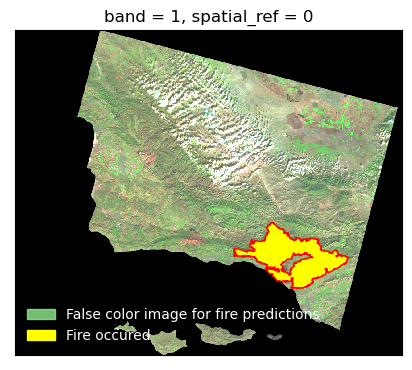

In [4]:
# load the nc data
data_path = os.path.join(os.getcwd(), "data/landsat8-2018-01-26-sb-simplified.nc")
landsat = rioxr.open_rasterio(data_path)

# squeeze the band
landsat1 = landsat.squeeze(['band'])

# make the crs same and also read the thompsons fire data+
fire = gpd.read_file("data/California_Fire_Perimeters_2017/California_Fire_Perimeters_2017.shp")
 
#select only thomas fire    
thomas_fire = fire[fire['FIRE_NAME'] == 'THOMAS']  

#change the crs                               
thomas_fire = thomas_fire.to_crs(landsat.rio.crs)

#also save the false color image as an object
false_color_data = landsat1[['swir22', 'nir08', 'red']].to_array()

# plot aoi outline and RGB raster together
fig, ax = plt.subplots(figsize=(5, 5))

false_color_data.plot.imshow(ax=ax, cmap='inferno', robust = True)
ak_patch = mpatches.Patch(color='lightgreen', alpha = 0.8,
                          label='False color image for fire predictions')

thomas_fire.plot(ax=ax, edgecolor = 'red', color= 'yellow', alpha = 1)
kodiak_patch = mpatches.Patch(color='yellow', alpha = 1,
                              label='Fire occured')

ax.legend(handles = [ak_patch, kodiak_patch], frameon=False, 
          loc='lower left',labelcolor = 'white' ) #create legend

ax.get_xaxis().set_visible(False) #remove xaxis label
ax.get_yaxis().set_visible(False) #remove yaxis label

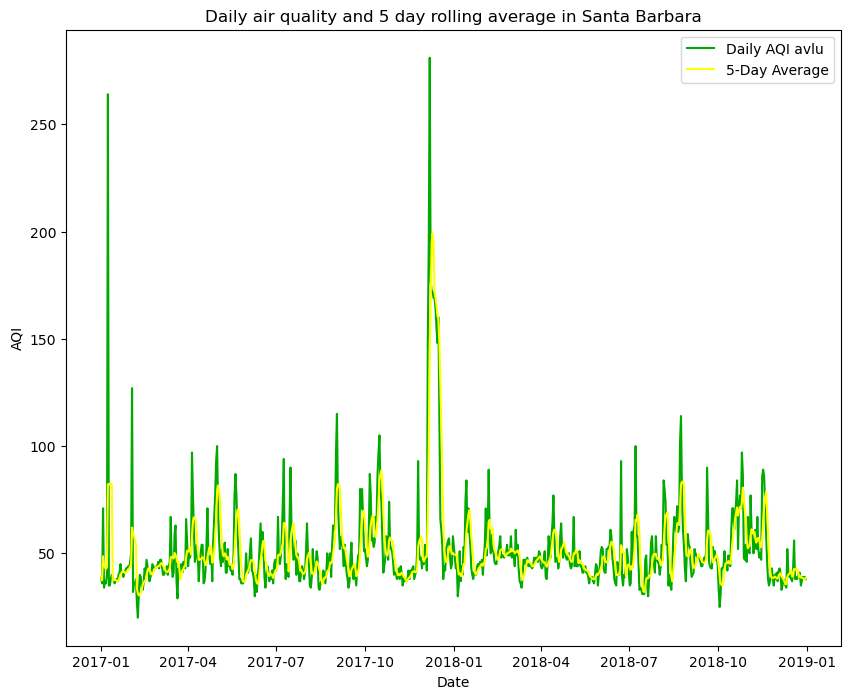

In [5]:
##air quality index
##webscrape the two dataset based on the guidelines

aqi_17 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip")
aqi_18 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip")

##concatnate the two datasets, its basically a rowbind
aqi = pd.concat([aqi_17, aqi_18])

# re-assign the column names - .str.lower() makes them lower case
aqi.columns = aqi.columns.str.lower()

#  re-assign the column names again - .str.replace(' ','_') replaces the space for _
aqi.columns = aqi.columns.str.replace(' ','_')

# Select data from Santa Barbara county
aqi_sb = aqi[aqi['county_name'] == 'Santa Barbara']

# Remove specified columns
col_remove = ['state_name', 'county_name', 'state_code', 'county_code']
aqi_sb = aqi_sb.drop(columns=col_remove)

##date is in object format, and not in standard datetime python object
# Convert 'Date' column to datetime
aqi_sb['date'] = pd.to_datetime(aqi_sb['date'])  

# Set 'Date' as the index
aqi_sb.set_index('date', inplace=True)

#  DataFrame with the Date column as the index
aqi_sb['five_day_average'] = aqi_sb.aqi.rolling('5D').mean()

# Create a line plot using base matplotlib
plt.figure(figsize=(10, 8))
plt.plot(aqi_sb.index, aqi_sb['aqi'], label='Daily AQI avlu', color='#00AA00')
plt.plot(aqi_sb.index, aqi_sb['five_day_average'], label='5-Day Average', color='#FFFF00')

# Set the title and labels
plt.title('Daily air quality and 5 day rolling average in Santa Barbara')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()

plt.show()